In [286]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Получаем параметры модели $(a_1,a_2,a_3,a_4,\mu,\sigma^2) = \hat{\theta}$

In [5]:
train_data = pd.read_csv('train.csv')
current_visible_data = pd.read_csv('current_visible.csv')

xi = train_data[['x', 'y']].values
dzeta = train_data[['hidden_x', 'hidden_y']].values

In [6]:

def get_a(data):
    a = {
        (0, 1): 0,
        (1, 0): 0,
        (0,-1): 0,
        (-1, 0): 0}

    for sample in data['sample'].unique():
        traj = data[data['sample'] == sample]
        for t in range(len(traj) - 1):
            curr_state = (traj.iloc[t]['hidden_x'],traj.iloc[t]['hidden_y'])
            next_state = (traj.iloc[t+1]['hidden_x'],traj.iloc[t+1]['hidden_y'])
            a_type = next_state[0]-curr_state[0],next_state[1]-curr_state[1]
            if (a_type in a): a[a_type] += 1
    normalized_a = {key: value / sum(a.values()) for key, value in a.items()}
    return normalized_a

a = get_a(train_data)
print("оценка a1,a2,a3,a4:")
a


оценка a1,a2,a3,a4:


{(0, 1): 0.2072072072072072,
 (1, 0): 0.24774774774774774,
 (0, -1): 0.2702702702702703,
 (-1, 0): 0.2747747747747748}

In [11]:
xi = train_data[['x', 'y']].values
dzeta = train_data[['hidden_x', 'hidden_y']].values
mu= np.mean(xi - dzeta, axis=0)
sigma2 = np.var(xi - dzeta, ddof=0)
cov = sigma2 * np.eye(2)
print("Общая оценка μ =", mu)
print("Общая оценка σ²=", sigma2)

Общая оценка μ = [-0.31881062 -1.14982486]
Общая оценка σ²= 6.6584115193079025


## Восстанавливаем $\zeta$

In [962]:
from scipy.stats import multivariate_normal

def find_max_path(cur_xi,cur_zeta):
    P_max = 0
    max_path = None  
    for a_key, a_value in a.items():
        path = np.array(a_key)
        rv = multivariate_normal(mu + cur_zeta + path , cov)
        P_cur = a_value * rv.pdf(cur_xi)
        if(P_cur > P_max):
            max_path = path
            P_max = P_cur
    return max_path

<!-- 
Веселимся дальше.
$(\xi(t) \mid \zeta(t)) \sim \mathcal{N}(\zeta(t) + \mu, \sigma^2 I_{2 \times 2})$ -->

In [963]:
xi = current_visible_data[['x', 'y']].values
t = len(xi)
zeta = [np.array([0, 0])]
for i in range(1,t):
    zeta.append(find_max_path(xi[i-1],zeta[i-1]) + zeta[i-1])
zeta = np.array(zeta)
zeta

array([[ 0,  0],
       [ 0, -1],
       [-1, -1],
       [ 0, -1],
       [-1, -1],
       [-1, -2],
       [ 0, -2],
       [-1, -2],
       [-2, -2],
       [-3, -2],
       [-3, -3],
       [-4, -3],
       [-4, -2],
       [-3, -2],
       [-3, -3],
       [-4, -3],
       [-5, -3],
       [-6, -3],
       [-7, -3],
       [-7, -4],
       [-7, -5],
       [-6, -5],
       [-5, -5],
       [-5, -4],
       [-5, -5],
       [-4, -5],
       [-3, -5],
       [-4, -5],
       [-5, -5],
       [-5, -4],
       [-6, -4],
       [-6, -3],
       [-6, -4],
       [-5, -4],
       [-5, -3],
       [-6, -3],
       [-6, -2],
       [-6, -1],
       [-6, -2],
       [-6, -3],
       [-7, -3],
       [-6, -3],
       [-6, -2],
       [-7, -2]])

Вот так вот мы бахнули $\zeta$


## Рисуем Графики  

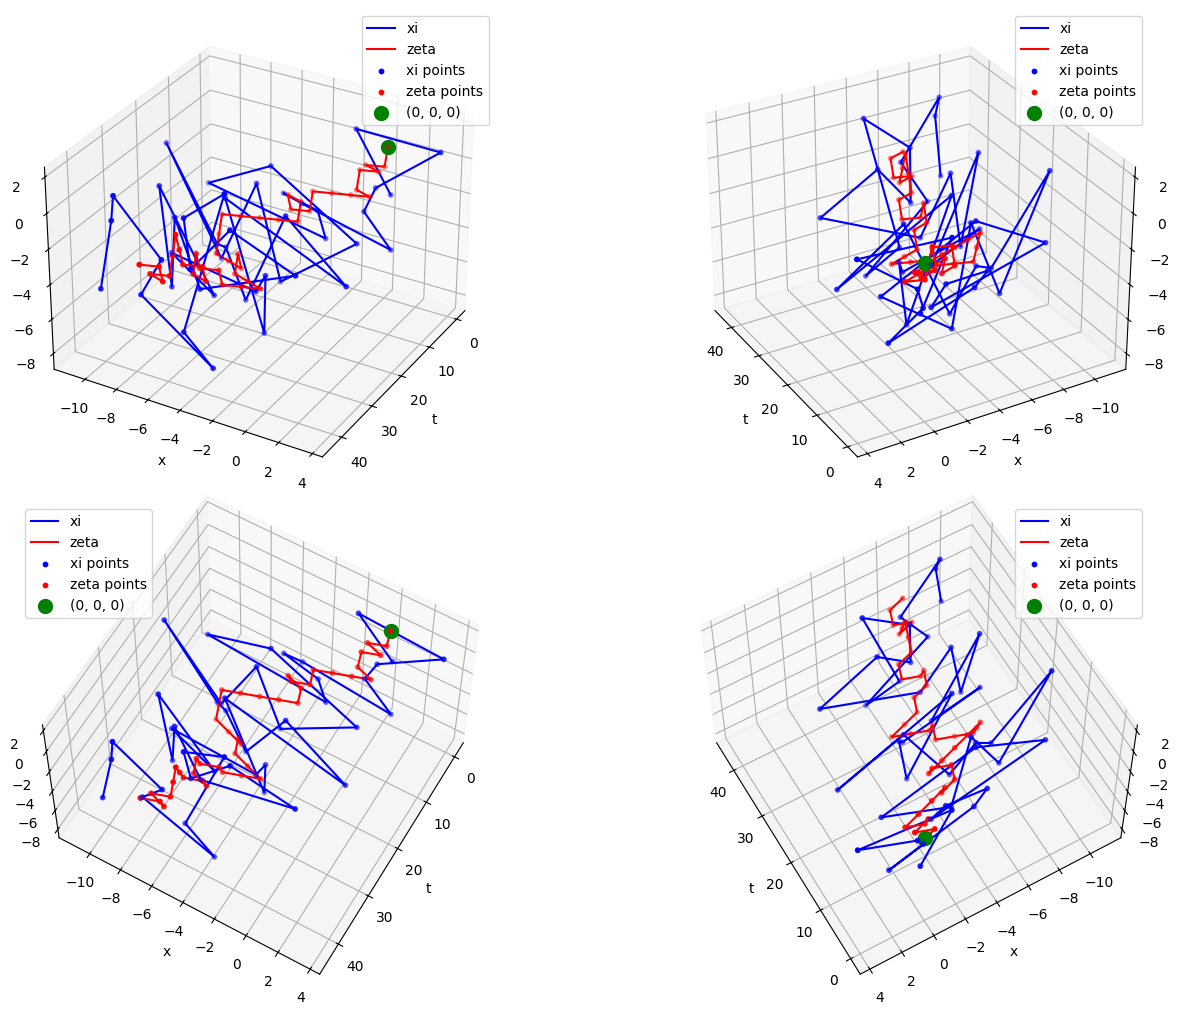

In [965]:
t = np.arange(len(xi))
xi_x, xi_y = xi[:, 0], xi[:, 1]
zeta_x, zeta_y = zeta[:, 0], zeta[:, 1]

# Создание фигуры и осей для 3D графика
fig = plt.figure(figsize=(15, 10))

# Создание подграфиков
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

# Функция для построения графика
def plot_graph(ax, elev, azim):
    ax.plot(t, xi_x, xi_y, label='xi', color='b')
    ax.plot(t, zeta_x, zeta_y, label='zeta', color='r')
    ax.scatter(t, xi_x, xi_y, color='b', s=10, label='xi points')
    ax.scatter(t, zeta_x, zeta_y, color='r', s=10, label='zeta points')
    ax.scatter([0], [0], [0], color='g', s=100, label='(0, 0, 0)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    ax.legend()
    ax.view_init(elev=elev, azim=azim)

# Построение графиков с разных углов
plot_graph(ax1, elev=30, azim=30)
plot_graph(ax2, elev=30, azim=150)
plot_graph(ax3, elev=60, azim=30)
plot_graph(ax4, elev=60, azim=150)

# Отображение графика
plt.tight_layout()
plt.show()

# Теперь делаем прогнозы $\xi$ и $\zeta$

In [950]:

def new_zeta(prev_zeta,a):
    values = list(a.keys())
    probs = list(a.values())

    values_array = np.arange(len(values))

    random_index = np.random.choice(values_array, p=probs)
    return values[random_index] + prev_zeta

zeta1 = new_zeta(zeta[-1],a)
zeta2 = new_zeta(zeta1,a)
print(f"zeta(n+1): {zeta1}")
print(f"zeta(n+2): {zeta2}")


zeta(n+1): [-8 -2]
zeta(n+2): [-7 -2]


In [961]:
def new_xi(zeta):
    return multivariate_normal(mu + zeta, cov).rvs()

xi1 = new_xi(zeta1)
xi2 = new_xi(zeta2)
print(f"xi(n+1): {xi1}")
print(f"xi(n+2): {xi2}")

xi(n+1): [-8.25677636 -5.09673145]
xi(n+2): [-8.51400566 -1.35750184]
